In [2]:
import helper_functions as zero

from demand import LinearDemand, ExponentialDemand
from instance import Backlog, LostSales
from inventory_state import ZeroLeadTime, ErlangLeadTime
from policy import ZeroLeadTimePolicy, ErlangLeadTimePolicy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

## Linear Demand Numerics

In [50]:
a = 10
b = 1/200
lin_demand = LinearDemand(a=a, b=b)

linear_df = pd.DataFrame([], 
                         columns = [
                             'K', 'h', 
                             'instance', 
                             'policy',
                             'result',
                             'static_policy', 
                             'static_result',
                             'optimal_static_policy',
                             'optimal_static_result',
                             'static_policy_adj', 
                             'static_result_adj',
                             'optimal_static_policy_adj',
                             'optimal_static_result_adj'
                         ])
for K in np.linspace(500, 5000, 10):
    for h in [(i+1)*0.50 for i in range(10)]:
        instance = LostSales(h=h, K=K, pi=0)
        profit, S = zero.optimal_profit_and_S(lin_demand, instance)
        print(K,h,profit,S)
        rates = zero.optimal_dynamic_policy_known_profit(0, S, lin_demand, instance, profit)
        state_space = ZeroLeadTime(s=0, S=S)
        policy = ZeroLeadTimePolicy(instance=instance, demand=lin_demand, state_space=state_space)
        policy.rates = rates
        result = policy.result
        
        static_rates = zero.static_rates(rates)
        static_policy = ZeroLeadTimePolicy(instance=instance, demand=lin_demand, state_space=state_space)
        static_policy.rates = static_rates
        static_result = static_policy.result
        
        opt_s_rate = zero.optimal_static_rate_fixed_S(instance, lin_demand, S)
        opt_s_policy = ZeroLeadTimePolicy(instance=instance, demand=lin_demand, state_space=state_space)
        opt_s_policy.rates = np.array([opt_s_rate for _ in range(S)])
        opt_s_result = opt_s_policy.result
        
        S_static = int(np.ceil(S / np.sqrt(static_result.holding_cost_ratio(result))))
        static_state_space = ZeroLeadTime(s=0, S=S_static)
        static_policy_adj = ZeroLeadTimePolicy(instance=instance, demand=lin_demand, state_space=static_state_space)
        static_policy_adj.rates = policy.static_rate * np.ones(static_state_space.shape)
        static_result_adj = static_policy_adj.result
                                        
        opt_rate_adj, opt_S = zero.optimal_static_policy(instance, lin_demand)
        opt_state_space = ZeroLeadTime(s=0, S=opt_S)
        opt_policy_adj = ZeroLeadTimePolicy(instance=instance, demand=lin_demand, state_space=opt_state_space)
        opt_policy_adj.rates = np.array([opt_rate_adj for _ in range(opt_S)])
        opt_result_adj = opt_policy_adj.result
        
        # static_result = zero.total_result(0, S, lin_demand, instance, static_rates(rates))
        linear_df = pd.concat([linear_df, pd.DataFrame(
            {
                "K": K, "h": h,"instance": instance, 
                "policy": policy, "result": result,
                "static_policy": static_policy, "static_result": static_result,
                "optimal_static_policy":opt_s_policy, "optimal_static_result": opt_s_result,
                "static_policy_adj": static_policy_adj, "static_result_adj": static_result_adj,
                "optimal_static_policy_adj":opt_policy_adj, "optimal_static_result_adj": opt_result_adj
            }, 
            index=[0])], 
                              ignore_index=True)

500.0 0.5 450.17378521063733 99
500.0 1.0 429.64309850285076 70
500.0 1.5 413.93550480583485 57
500.0 2.0 400.72573870239125 49
500.0 2.5 389.1131405913768 44
500.0 3.0 378.6364271117293 40
500.0 3.5 369.0197213736326 37
500.0 4.0 360.0728297330704 34
500.0 4.5 351.6948486975764 32
500.0 5.0 343.79312285577157 31
1000.0 0.5 429.8931321901307 140
1000.0 1.0 401.2258781940261 98
1000.0 1.5 379.3867496237624 80
1000.0 2.0 361.08585284958394 69
1000.0 2.5 345.0447216412442 61
1000.0 3.0 330.62258498026154 56
1000.0 3.5 317.41481162382 52
1000.0 4.0 305.1810695658048 48
1000.0 4.5 293.73510467118535 45
1000.0 5.0 282.96208367530085 43
1500.0 0.5 414.4355962936572 171
1500.0 1.0 379.6368093483977 120
1500.0 1.5 353.20812583037764 97
1500.0 2.0 331.122840566735 84
1500.0 2.5 311.81630575420627 75
1500.0 3.0 294.4906866592589 68
1500.0 3.5 278.6661570653166 63
1500.0 4.0 264.03124031830316 58
1500.0 4.5 250.38697632871276 55
1500.0 5.0 237.55683106483616 52
2000.0 0.5 401.4760290146171 197
200

In [52]:
revenues = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.revenue)
costs = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.costs)
holds = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.holding)
orders = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.ordering)

row_order = [revenues, costs, holds, orders]
# column_order = ["static_result", "static_result_adj", "optimal_static_result", "optimal_static_result_adj"]
column_order = ["static_result", "optimal_static_result", "optimal_static_result_adj"]

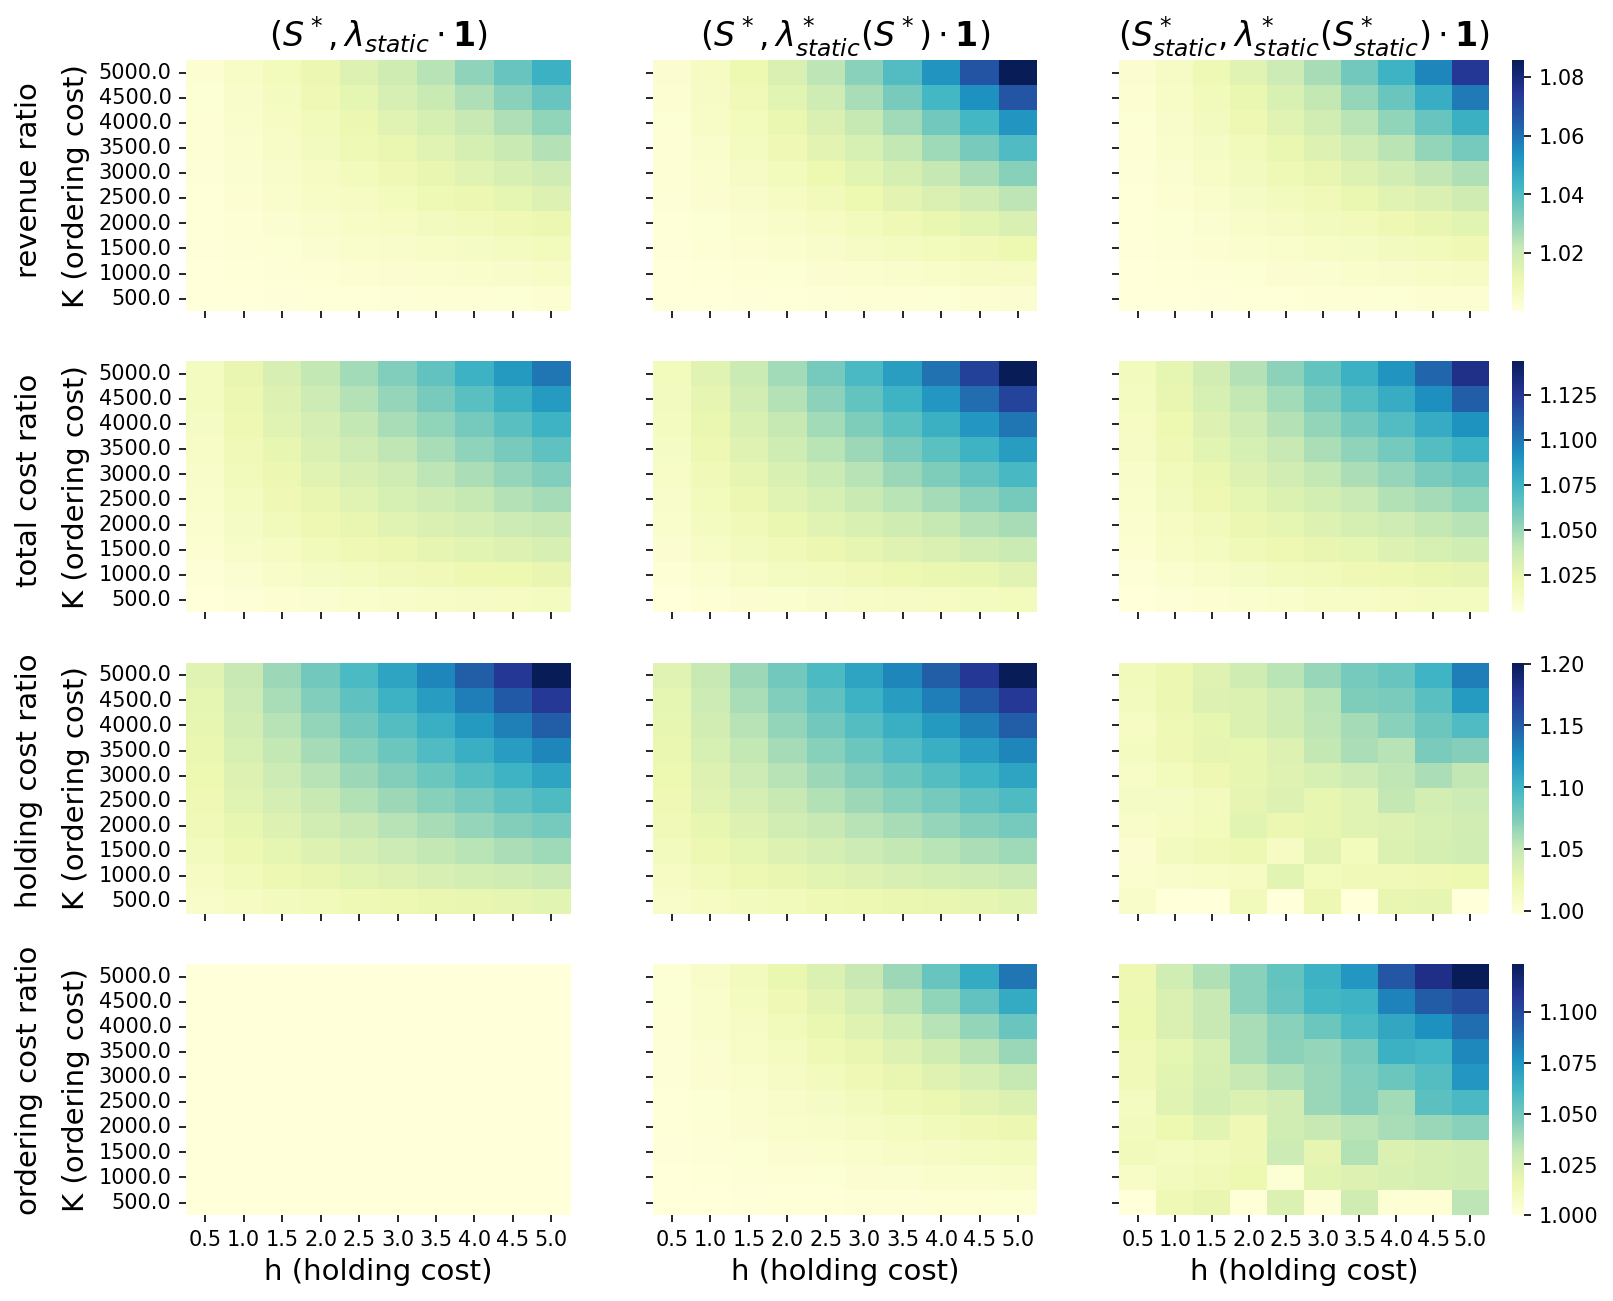

In [63]:
num_policy = 3
num_metric = 4
fig, axes = plt.subplots(
    num_metric, num_policy, 
    figsize=(4*num_policy,2.5*num_metric), dpi=150, 
    sharex=True, sharey=True,
    gridspec_kw={'width_ratios':[1,1,1.2]}
)

row_labels = ['revenue ratio', 'total cost ratio', 'holding cost ratio', 'ordering cost ratio']
col_labels = [
    '$(S^*, \lambda_{static} \cdot \mathbf{1})$', '$(S_{static}, \lambda_{static} \cdot \mathbf{1})$', 
    '$(S^*, \lambda_{static}^*(S^*) \cdot \mathbf{1})$', 
    '$(S^*_{static}, \lambda_{static}^*(S^*_{static}) \cdot \mathbf{1})$'
]
col_labels = [
    '$(S^*, \lambda_{static} \cdot \mathbf{1})$', 
    '$(S^*, \lambda_{static}^*(S^*) \cdot \mathbf{1})$', 
    '$(S^*_{static}, \lambda_{static}^*(S^*_{static}) \cdot \mathbf{1})$'
]
for r in range(num_metric):
    row_df = pd.concat([row_order[r].div(row_order[r].result, axis=0), linear_df[["K","h"]]], axis=1)
    vmax = row_df[column_order].where(row_df[column_order]>0).max().max()
    vmin = row_df[column_order].where(row_df[column_order]>0).min().min()
    for c in range(num_policy):
        table = row_df.pivot("K", "h", column_order[c])
        if c == num_policy - 1:
            ax = sns.heatmap(table, cmap="YlGnBu", ax=axes[r][c], vmax=vmax, vmin=vmin)
        else:
            ax = sns.heatmap(table, cmap="YlGnBu", ax=axes[r][c], cbar=False, vmax=vmax, vmin=vmin)
        ax.set(xlabel=None, ylabel=None)
        ax.invert_yaxis()
        
        if r == 0:
            ax.set_title(col_labels[c], fontsize=16)
        if c == 0:
            ax.set_ylabel('K (ordering cost)', fontsize=14)
        if r == num_metric - 1:
            ax.set_xlabel('h (holding cost)', fontsize=14)

for i, label in enumerate(row_labels): 
    fig.text(0.03, 0.2*(len(row_labels) - i), label, va='center', rotation='vertical', fontsize=14)

# fig.text(
#     0.5, 0, "Comparison of revenue and cost ratios across policies (Linear demand)", 
#     ha='center', fontsize=16
# )

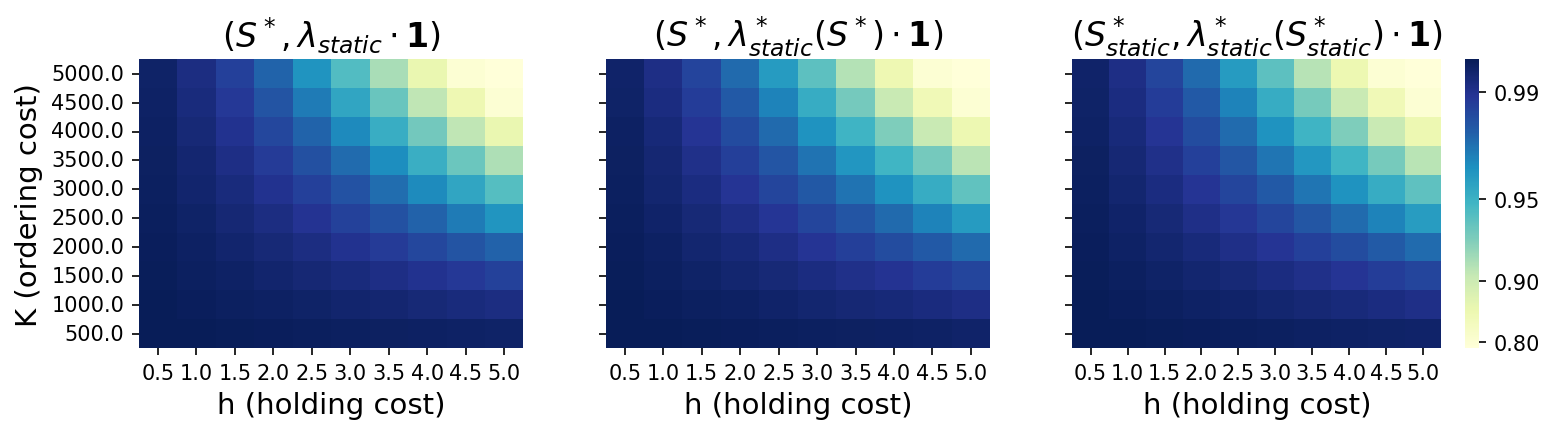

In [64]:
profits = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.profit)

num_metric = 1
fig, axes = plt.subplots(
    num_metric, num_policy, 
    figsize=(4*num_policy,2.5*num_metric), dpi=150, 
    sharex=True, sharey=True,
    gridspec_kw={'width_ratios':[1,1,1.2]}
)

row_labels = ['profit gap (abs.)', 'profit gap (%)']

row_df = pd.concat([profits.div(profits.result, axis=0), linear_df[["K","h"]]], axis=1)
for c in range(num_policy):
    vmax = row_df[column_order].where(row_df[column_order]>0).max().max()
    vmin = row_df[column_order].where(row_df[column_order]>0).min().min()
    table = row_df.pivot("K", "h", column_order[c])
    cmap = "YlGnBu"
    if c == num_policy - 1:
        ticks = [0.99, 0.95, 0.9, 0.8]
        ax = sns.heatmap(table, cmap=cmap, ax=axes[c], vmax=vmax, vmin=vmin, norm=PowerNorm(gamma=4), cbar_kws=dict(ticks=ticks))
    else:
        ax = sns.heatmap(table, cmap=cmap, ax=axes[c], cbar=False, vmax=vmax, vmin=vmin, norm=PowerNorm(gamma=4))
    ax.set(xlabel=None, ylabel=None)
    ax.invert_yaxis()

    ax.set_title(col_labels[c], fontsize=16)
    if c == 0:
        ax.set_ylabel("K (ordering cost)", fontsize=14)
    ax.set_xlabel('h (holding cost)', fontsize=14)

# fig.text(0.5, -0.25, 'Profit ratio for different static policies (Linear demand)', fontsize=16, ha='center')

Text(0.5, 1.0, '$(S^*, \\mathbf{\\lambda}^*)$')

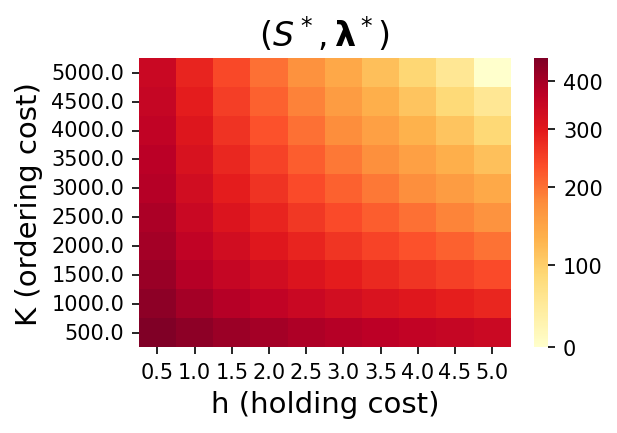

In [31]:
profits = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.profit)
data_df = pd.concat([profits.result, linear_df[["K","h"]]], axis=1)
vmax = data_df.result.max()
vmin = data_df.result.min()
table = data_df.pivot("K", "h", "result")

fig, ax = plt.subplots(
    1, 1, dpi=150, figsize=(4,2.5)
)
cmap = "YlOrRd"
ax = sns.heatmap(table, cmap=cmap, ax=ax, vmax=vmax, vmin=vmin, norm=PowerNorm(0.6))
ax.set_ylabel("K (ordering cost)", fontsize=14)
ax.set_xlabel("h (holding cost)", fontsize=14)
ax.invert_yaxis()
# fig.text(0.38, -0.25, 'Optimal dynamic profit', fontsize=16, ha='center')
ax.set_title("$(S^*, \mathbf{\lambda}^*)$", fontsize=16)

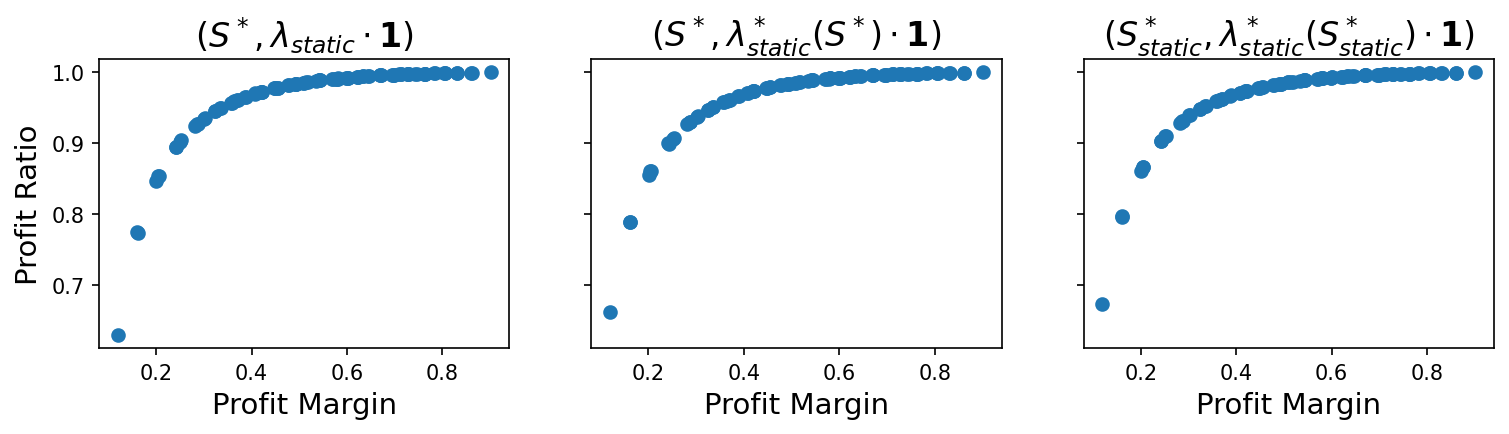

In [65]:
# profit margin vs profit gap
revenues = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.revenue)
profits = linear_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.profit)
margins = profits.result.div(revenues.result, axis=0)
ratios = profits.div(profits.result, axis=0)


fig, axes = plt.subplots(
    1, num_policy, 
    figsize=(4*num_policy,2.5), dpi=150, 
    sharex=True, sharey=True,
)
for c, ax in enumerate(axes):
    ax.scatter(margins, ratios[column_order[c]])
    # ax.scatter(margins, 1 - 5/margins - 400/margins**2,s=1)
    ax.set_title(col_labels[c], fontsize=16)
    if c == 0:
        ax.set_ylabel("Profit Ratio", fontsize=14)
    ax.set_xlabel("Profit Margin", fontsize=14)
# fig.text(0.5, -0.25, "Profit Ratio vs. Profit Margin for different static policies (Linear demand)", fontsize= 16, ha='center')

## Exp Demand Numerics

In [51]:
a = 10
b = 1/100
exp_demand = ExponentialDemand(a=a, b=b)

exponential_df = pd.DataFrame([], 
                              columns = [
                                  'K', 'h', 
                                  'instance', 
                                  'policy',
                                  'result',
                                  'static_policy', 
                                  'static_result',
                                  'optimal_static_policy',
                                  'optimal_static_result',
                                  'static_policy_adj', 
                                  'static_result_adj',
                                  'optimal_static_policy_adj',
                                  'optimal_static_result_adj'
                              ])
for K in np.linspace(500, 5000, 10):
    for h in [(i+1)*0.5 for i in range(10)]:
        instance = LostSales(h=h, K=K, pi=0)
        profit, S = zero.optimal_profit_and_S(exp_demand, instance)
        rates = zero.optimal_dynamic_policy_known_profit(0, S, exp_demand, instance, profit)
        state_space = ZeroLeadTime(s=0, S=S)
        policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
        policy.rates = rates
        result = policy.result
        
        static_rates = zero.static_rates(rates)
        static_policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
        static_policy.rates = static_rates
        static_result = static_policy.result
        
        opt_s_rate = zero.optimal_static_rate_fixed_S(instance, exp_demand, S)
        opt_s_policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
        opt_s_policy.rates = np.array([opt_s_rate for _ in range(S)])
        opt_s_result = opt_s_policy.result
        
        S_static = int(np.ceil(S / np.sqrt(static_result.holding_cost_ratio(result))))
        static_state_space = ZeroLeadTime(s=0, S=S_static)
        static_policy_adj = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=static_state_space)
        static_policy_adj.rates = policy.static_rate * np.ones(static_state_space.shape)
        static_result_adj = static_policy_adj.result
                                        
        opt_rate_adj, opt_S = zero.optimal_static_policy(instance, exp_demand)
        opt_state_space = ZeroLeadTime(s=0, S=opt_S)
        opt_policy_adj = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=opt_state_space)
        opt_policy_adj.rates = np.array([opt_rate_adj for _ in range(opt_S)])
        opt_result_adj = opt_policy_adj.result
        
        # static_result = zero.total_result(0, S, lin_demand, instance, static_rates(rates))
        exponential_df = pd.concat([exponential_df, pd.DataFrame(
            {
                "K": K, "h": h,"instance": instance, 
                "policy": policy, "result": result,
                "static_policy": static_policy, "static_result": static_result,
                "optimal_static_policy":opt_s_policy, "optimal_static_result": opt_s_result,
                "static_policy_adj": static_policy_adj, "static_result_adj": static_result_adj,
                "optimal_static_policy_adj":opt_policy_adj, "optimal_static_result_adj": opt_result_adj
            }, 
            index=[0])], 
                              ignore_index=True)

In [66]:
revenues = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.revenue)
costs = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.costs)
holds = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.holding)
orders = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.ordering)

# row_order = [revenues, costs, holds, orders]
# column_order = ["static_result", "static_result_adj", "optimal_static_result", "optimal_static_result_adj"]

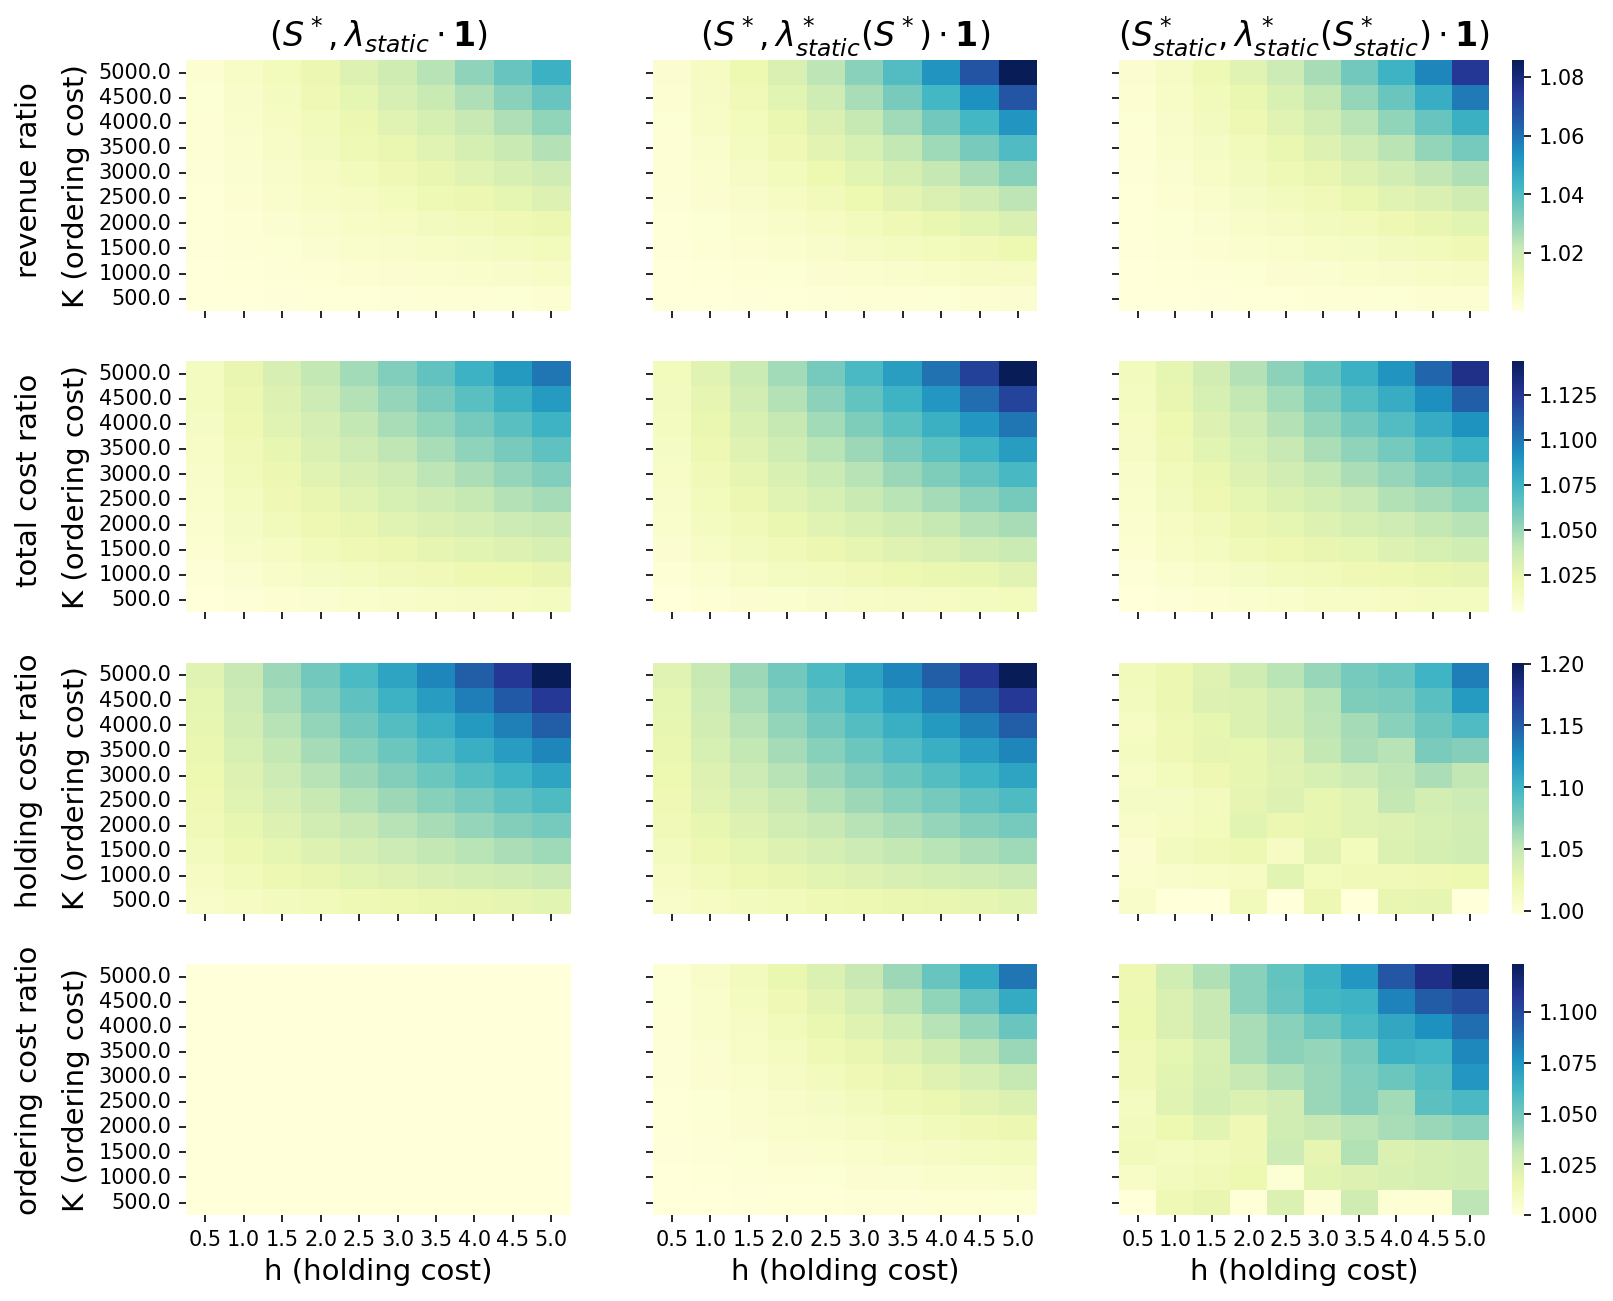

In [67]:
# num_policy = 4
num_metric = 4
fig, axes = plt.subplots(
    num_metric, num_policy, 
    figsize=(4*num_policy,2.5*num_metric), dpi=150, 
    sharex=True, sharey=True,
    gridspec_kw={'width_ratios':[1,1,1.2]}
)

row_labels = ['revenue ratio', 'total cost ratio', 'holding cost ratio', 'ordering cost ratio']
# col_labels = [
#     '$(S^*, \lambda_{static} \cdot \mathbf{1})$', '$(S_{static}, \lambda_{static} \cdot \mathbf{1})$', 
#     '$(S^*, \lambda_{static}^*(S^*) \cdot \mathbf{1})$', 
#     '$(S^*_{static}, \lambda_{static}^*(S^*_{static}) \cdot \mathbf{1})$'
# ]

for r in range(num_metric):
    row_df = pd.concat([row_order[r].div(row_order[r].result, axis=0), exponential_df[["K","h"]]], axis=1)
    vmax = row_df[column_order].where(row_df[column_order]>0).max().max()
    vmin = row_df[column_order].where(row_df[column_order]>0).min().min()
    for c in range(num_policy):
        table = row_df.pivot("K", "h", column_order[c])
        if c == num_policy - 1:
            ax = sns.heatmap(table, cmap="YlGnBu", ax=axes[r][c], vmax=vmax, vmin=vmin)
        else:
            ax = sns.heatmap(table, cmap="YlGnBu", ax=axes[r][c], cbar=False, vmax=vmax, vmin=vmin)
        ax.set(xlabel=None, ylabel=None)
        ax.invert_yaxis()
        
        if r == 0:
            ax.set_title(col_labels[c], fontsize=16)
        if c == 0:
            ax.set_ylabel('K (ordering cost)', fontsize=14)
        if r == num_metric - 1:
            ax.set_xlabel('h (holding cost)', fontsize=14)

for i, label in enumerate(row_labels): 
    fig.text(0.03, 0.2*(len(row_labels) - i), label, va='center', rotation='vertical', fontsize=14)
    
# fig.text(
#     0.5, 0.93, "Comparison of revenue and cost ratios across policies (Exponential demand)", 
#     ha='center', fontsize=16
# )

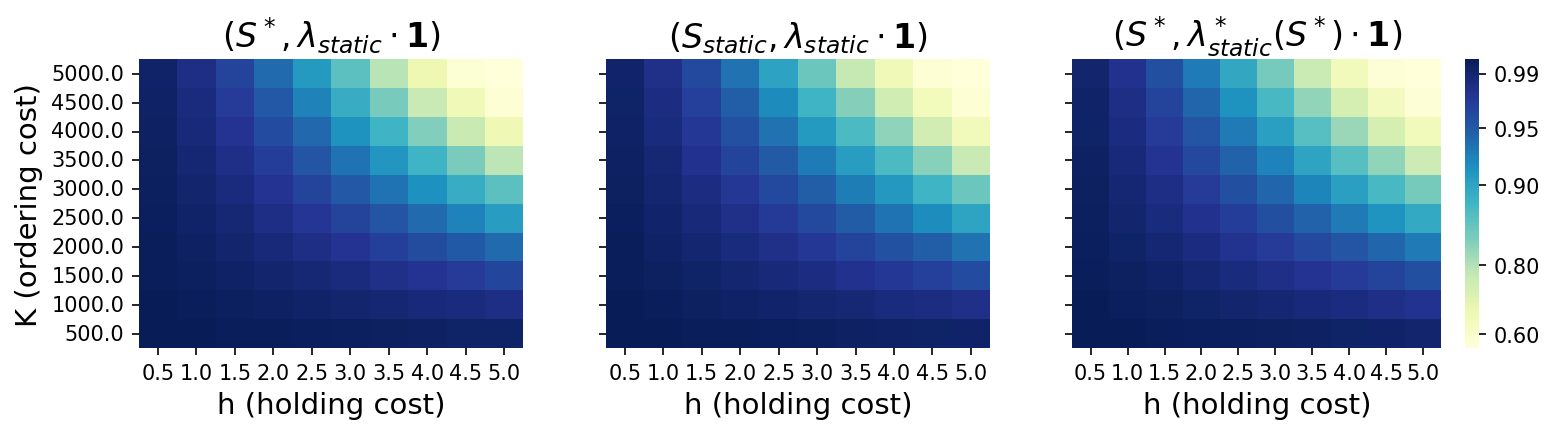

In [70]:
profits = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.profit)

num_policy = 3
num_metric = 1
fig, axes = plt.subplots(
    num_metric, num_policy, 
    figsize=(4*num_policy,2.5*num_metric), dpi=150, 
    sharex=True, sharey=True,
    gridspec_kw={'width_ratios':[1,1,1.2]}
)

row_labels = ['profit gap (abs.)', 'profit gap (%)']
# col_labels = [
#     '$(S^*, \lambda_{static} \cdot \mathbf{1})$', '$(S_{static}, \lambda_{static} \cdot \mathbf{1})$', 
#     '$(S^*, \lambda_{static}^*(S^*) \cdot \mathbf{1})$', 
#     '$(S^*_{static}, \lambda_{static}^*(S^*_{static}) \cdot \mathbf{1})$'
# ]


row_df = pd.concat([profits.div(profits.result, axis=0), exponential_df[["K","h"]]], axis=1)
for c in range(num_policy):
    vmax = row_df[column_order].where(row_df[column_order]>0).max().max()
    vmin = row_df[column_order].where(row_df[column_order]>0).min().min()
    table = row_df.pivot("K", "h", column_order[c])
    cmap = "YlGnBu"
    if c == num_policy - 1:
        ticks = [0.99, 0.95, 0.9, 0.8, 0.6]
        ax = sns.heatmap(table, cmap=cmap, ax=axes[c], vmax=vmax, vmin=vmin, norm=PowerNorm(gamma=4), cbar_kws=dict(ticks=ticks))
    else:
        ax = sns.heatmap(table, cmap=cmap, ax=axes[c], cbar=False, vmax=vmax, vmin=vmin, norm=PowerNorm(gamma=4))
    ax.set(xlabel=None, ylabel=None)
    ax.invert_yaxis()

    ax.set_title(col_labels[c], fontsize=16)
    if c == 0:
        ax.set_ylabel("K (ordering cost)", fontsize=14)
    ax.set_xlabel('h (holding cost)', fontsize=14)

# fig.text(0.5, -0.25, 'Profit ratio for different static policies (Exponential demand)', fontsize=16, ha='center')

Text(0.5, 1.0, '$(S^*, \\mathbf{\\lambda}^*)$')

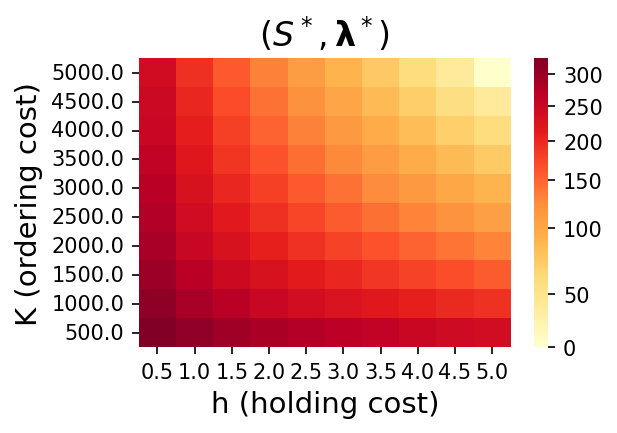

In [40]:
profits = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.profit)
data_df = pd.concat([profits.result, exponential_df[["K","h"]]], axis=1)
vmax = data_df.result.max()
vmin = data_df.result.min()
table = data_df.pivot("K", "h", "result")

fig, ax = plt.subplots(
    1, 1, dpi=150, figsize=(4,2.5)
)
cmap = "YlOrRd"
ax = sns.heatmap(table, cmap=cmap, ax=ax, vmax=vmax, vmin=vmin, norm=PowerNorm(0.6))
ax.set_ylabel("K (ordering cost)", fontsize=14)
ax.set_xlabel("h (holding cost)", fontsize=14)
ax.invert_yaxis()
# fig.text(0.38, -0.25, 'Optimal dynamic profit', fontsize=16, ha='center')
ax.set_title("$(S^*, \mathbf{\lambda}^*)$", fontsize=16)

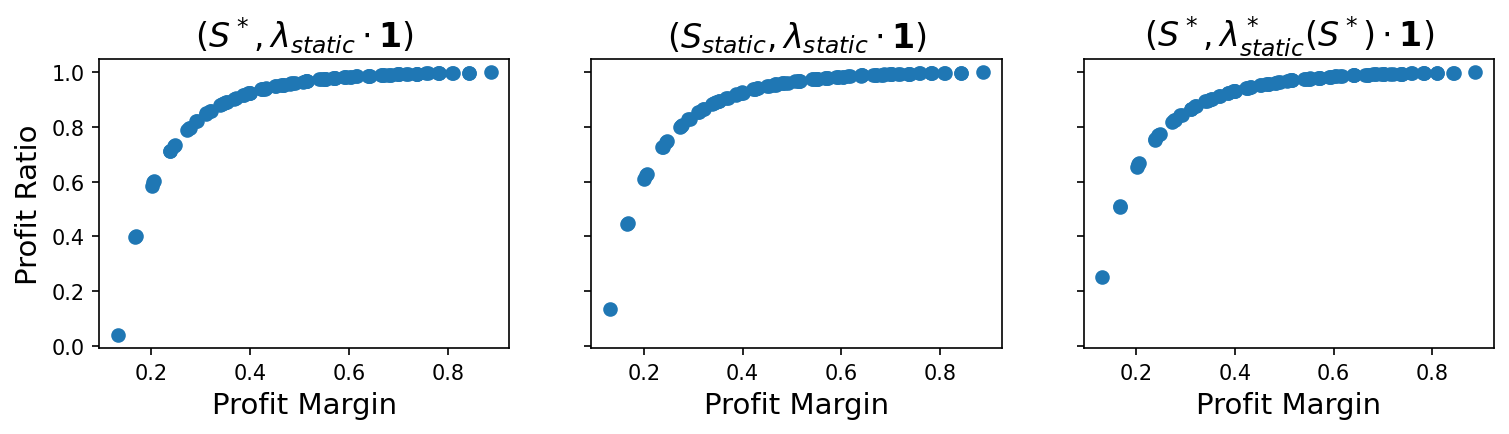

In [71]:
# profit margin vs profit gap
profits = exponential_df[["result", "static_result", "optimal_static_result", "static_result_adj", "optimal_static_result_adj"]]\
    .applymap(lambda x: x.profit)
margins = profits.result.div(revenues.result, axis=0)
ratios = profits.div(profits.result, axis=0)

# num_policy=4

# col_labels = [
#     '$(S^*, \lambda_{static} \cdot \mathbf{1})$', '$(S_{static}, \lambda_{static} \cdot \mathbf{1})$', 
#     '$(S^*, \lambda_{static}^*(S^*) \cdot \mathbf{1})$', 
#     '$(S^*_{static}, \lambda_{static}^*(S^*_{static}) \cdot \mathbf{1})$'
# ]

fig, axes = plt.subplots(
    1, num_policy, 
    figsize=(4*num_policy,2.5), dpi=150, 
    sharex=True, sharey=True,
)
for c, ax in enumerate(axes):
    ax.scatter(margins, ratios[column_order[c]])
    ax.set_title(col_labels[c], fontsize=16)
    if c == 0:
        ax.set_ylabel("Profit Ratio", fontsize=14)
    ax.set_xlabel("Profit Margin", fontsize=14)
# fig.text(0.5, -0.25, "Profit Ratio vs. Profit Margin for different static policies (Exponential demand)", fontsize= 16, ha='center')

In [137]:
pd.set_option("display.precision", 4)
profits.div(profits.result, axis=0)[column_order].agg(['mean', 'std', 'min']).T

,mean,std,min
static_result,0.9128,0.1467,0.0396
static_result_adj,0.9248,0.1188,0.2507
optimal_static_result,0.9171,0.1349,0.1352
optimal_static_result_adj,0.9249,0.1187,0.2519


## Proof of Theorem 3 (Linear demand changing S)

In [286]:
# Linear demand
length = 400
num = 0
den = 0
ratios = []
for i in range(1,length):
    num += i**0.5
    den += i**(-0.5)
    static = (i+1) / 2
    dyn = num / den
    alpha = static / dyn
    new_i = np.ceil(-0.5+(0.25+i*(i+1)/alpha)**0.5)
    new_static = (new_i+1) / 2
    ratio = new_static / dyn
    ratios.append(ratio)

In [48]:
# Linear demand
length = 25
num = 0
den = 0
ratios = []
for i in range(1,length):
    num += i**0.5
    den += i**(-0.5)
    static = (i+1) / 2
    dyn = num / den
    alpha = static / dyn
    new_i = np.ceil(i/1.5**0.5)
    new_static = (new_i+1) / 2
    ratio = new_static / dyn
    ratios.append(ratio)

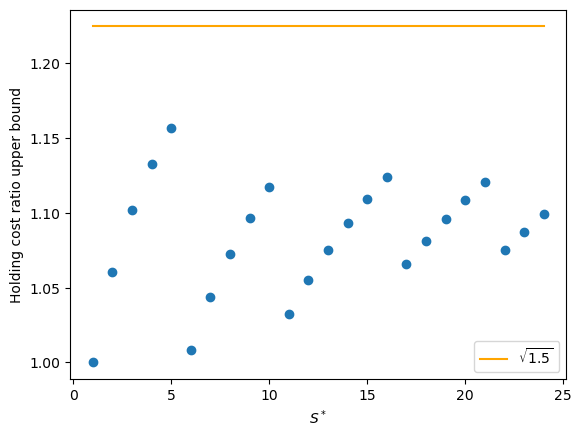

In [49]:
plt.scatter(np.arange(1,length), ratios)
plt.plot(np.arange(1,length), np.ones(length-1)*np.sqrt(1.5), color="orange", label="$\sqrt{1.5}$")
plt.ylabel("Holding cost ratio upper bound")
plt.xlabel("$S^*$")
plt.legend()
plt.show()

## Optimal and static rates for backlogging

In [33]:
a = 30
b = 1/15
lin_demand = LinearDemand(a=a, b=b)
s = -11
S = 200
profit = 2
# instance = lin_demand.optimal_instance_zero_leadtime(s=s, S=S, profit=profit)
h = zero.h_lin(S, lin_demand, profit)
pi = zero.pi_lin(s, lin_demand, profit)
K = zero.K_lin(s, S, lin_demand, profit)
instance = Backlog(K=K, h=h, pi=pi)
state_space = ZeroLeadTime(s=s, S=S)
profit = zero.optimal_profit(lin_demand, instance, s, S)
states = np.arange(s+1, S+1)
optimal_rates = np.sqrt(a * b * (profit + instance.holding(states)))
three_price_rates = zero.three_price_policy(s, S, optimal_rates)

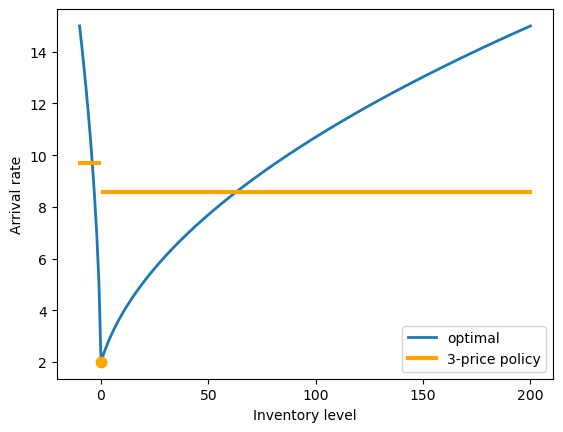

In [35]:
plt.plot(states, optimal_rates, label="optimal", linewidth=2)
plt.plot(states[states < 0], three_price_rates[:-s-1], label="3-price policy", linewidth=3, color="orange")
plt.plot(0, three_price_rates[-s-1], marker=".", color="orange", markersize=15)
plt.plot(states[states > 0], three_price_rates[-s:], color="orange", linewidth=3)
plt.xlabel("Inventory level")
plt.ylabel("Arrival rate")
# plt.title("Optimal rates vs 3-price arrival rates with backlogging")
plt.legend()
plt.show()

## Profit Margin vs Profit Ratio

In [39]:
np.random.seed(2023)
samples = 1500
profit_dyn = []
profit_stat = []
revenue_dyn = []
for i in range(samples):
    K = np.random.rand()*9900.0 + 100
    h = np.random.rand()*9.9 + 0.1
    a = np.random.rand()*5
    b = np.random.rand()*0.0015 + 0.0005
    if i == 387:
        print(K, h, a, b)
    exp_demand = ExponentialDemand(a=a, b=b)
    instance = LostSales(h=h, K=K, pi=0)
    
    profit, S = zero.optimal_profit_and_S(exp_demand, instance)
    rates = zero.optimal_dynamic_policy_known_profit(0, S, exp_demand, instance, profit)
    state_space = ZeroLeadTime(s=0, S=S)
    policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
    policy.rates = rates
    result = policy.result
    if policy.result.profit <= 0:
        print(i, "Negative profit")
        continue
    print(i, S)
    print(result)

#     static_rates = zero.static_rates(rates)
#     static_policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
#     static_policy.rates = static_rates
#     static_result = static_policy.result

#     opt_s_rate = zero.optimal_static_rate_fixed_S(instance, exp_demand, S)
#     opt_s_policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
#     opt_s_policy.rates = np.array([opt_s_rate for _ in range(S)])
#     opt_s_result = opt_s_policy.result

#     S_static = int(np.ceil(S / np.sqrt(static_result.holding_cost_ratio(result))))
#     static_state_space = ZeroLeadTime(s=0, S=S_static)
#     static_policy_adj = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=static_state_space)
#     static_policy_adj.rates = policy.static_rate * np.ones(static_state_space.shape)
#     static_result_adj = static_policy_adj.result

    opt_rate_adj, opt_S = zero.optimal_static_policy(instance, exp_demand)
    opt_state_space = ZeroLeadTime(s=0, S=opt_S)
    opt_policy_adj = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=opt_state_space)
    opt_policy_adj.rates = np.array([opt_rate_adj for _ in range(opt_S)])
    opt_result_adj = opt_policy_adj.result
    
    if opt_S == 0:
        print("WUUUT")
        continue
    profit_dyn.append(result.profit)
    revenue_dyn.append(result.revenue)
    profit_stat.append(opt_result_adj.profit)

0 27
Profit: 1318.3974067581746
Revenue: 1560.8194251790337
Ordering Costs: 120.9566864025885
Holding Costs: 121.46533201827066
1 4
Profit: 3.241944160642481
Revenue: 20.828856094753117
Ordering Costs: 7.780687165266882
Holding Costs: 9.806224768843753
2 38
Profit: 459.25906220683936
Revenue: 657.564660566721
Ordering Costs: 97.624964466681
Holding Costs: 100.68063389320065
3 57
Profit: 801.9158394915614
Revenue: 891.6520002519168
Ordering Costs: 44.24865219640841
Holding Costs: 45.4875085639469
4 51
Profit: 1203.0099502858882
Revenue: 1298.2064888753541
Ordering Costs: 46.79659464604514
Holding Costs: 48.39994394342082
5 54
Profit: 437.96170538286833
Revenue: 549.346276642
Ordering Costs: 55.43874551923488
Holding Costs: 55.9458257398968
6 53
Profit: 993.9094932757516
Revenue: 1053.5868225921797
Ordering Costs: 29.482296028796693
Holding Costs: 30.195033287631325
7 32
Profit: 543.5412059143106
Revenue: 823.1462542516003
Ordering Costs: 136.68800218757843
Holding Costs: 142.91704614971

67 91
Profit: 332.18795312590447
Revenue: 431.6444239573345
Ordering Costs: 49.26408870296099
Holding Costs: 50.19238212846905
68 11
Profit: 41.54835503445528
Revenue: 78.00154577767444
Ordering Costs: 17.48707439660227
Holding Costs: 18.966116346616893
69 16
Profit: 223.45507358482274
Revenue: 321.159672553939
Ordering Costs: 46.99131160371835
Holding Costs: 50.71328736539788
70 49
Profit: 848.5600882654252
Revenue: 1146.212539051426
Ordering Costs: 146.01096604066035
Holding Costs: 151.6414847453403
71 63
Profit: 1136.6325784608664
Revenue: 1341.0485543474329
Ordering Costs: 101.56842616074933
Holding Costs: 102.84754972581702
72 Negative profit
73 32
Profit: 670.4899639859082
Revenue: 831.0888487902439
Ordering Costs: 79.2547344023125
Holding Costs: 81.34415040202327
74 64
Profit: 280.79304390448124
Revenue: 530.8713213167075
Ordering Costs: 123.42825526198142
Holding Costs: 126.65002215024484
75 21
Profit: 1601.1673548591748
Revenue: 1766.9652480818563
Ordering Costs: 80.3268715245

133 100
Profit: 1169.600990978367
Revenue: 1246.9498389244004
Ordering Costs: 38.542293416930384
Holding Costs: 38.80655452910303
134 Negative profit
135 15
Profit: 565.28039558244
Revenue: 682.2184577869373
Ordering Costs: 56.93152630713465
Holding Costs: 60.00653589736274
136 46
Profit: 649.1518269747652
Revenue: 892.7887441476174
Ordering Costs: 121.50785959136212
Holding Costs: 122.12905758149013
137 41
Profit: 445.90753548191947
Revenue: 784.0897330270765
Ordering Costs: 167.59780635799356
Holding Costs: 170.58439118716342
138 75
Profit: 1154.92717522066
Revenue: 1349.5450310856268
Ordering Costs: 96.79566597846733
Holding Costs: 97.82218988649953
139 37
Profit: 850.8012463889161
Revenue: 1172.0732583533763
Ordering Costs: 159.4916262147762
Holding Costs: 161.78038574968406
140 33
Profit: 679.6313379780145
Revenue: 952.0358618242919
Ordering Costs: 134.6657060236974
Holding Costs: 137.7388178225802
141 110
Profit: 636.5596657138157
Revenue: 832.1722176233267
Ordering Costs: 97.732

201 37
Profit: 660.694953283606
Revenue: 919.1881711079212
Ordering Costs: 127.791479739013
Holding Costs: 130.70173808530228
202 52
Profit: 1983.5370001750507
Revenue: 2395.6233955821435
Ordering Costs: 205.43837906417104
Holding Costs: 206.64801634292184
203 62
Profit: 665.1065199923671
Revenue: 785.9896791750359
Ordering Costs: 59.93651647520272
Holding Costs: 60.94664270746603
204 26
Profit: 99.8533736415218
Revenue: 144.40551721852637
Ordering Costs: 22.11075493132557
Holding Costs: 22.441388645678995
205 4
Profit: 3.5345444027172874
Revenue: 29.36293949827446
Ordering Costs: 11.683419077114179
Holding Costs: 14.144976018442996
206 36
Profit: 753.1466973331663
Revenue: 873.4210090831393
Ordering Costs: 59.841601985041585
Holding Costs: 60.43270976493136
207 51
Profit: 154.77271311041295
Revenue: 232.24172316733902
Ordering Costs: 38.41497791250777
Holding Costs: 39.05403214441831
208 12
Profit: 4.978980016317632
Revenue: 27.147537211821433
Ordering Costs: 10.356253011096003
Holdin

266 95
Profit: 618.5139812878224
Revenue: 689.5464563901336
Ordering Costs: 35.45413721820337
Holding Costs: 35.578337884107725
267 27
Profit: 823.4099389877804
Revenue: 991.7951759321876
Ordering Costs: 82.65793257986417
Holding Costs: 85.72730436454297
268 62
Profit: 1243.3873388419051
Revenue: 1355.2103341388356
Ordering Costs: 55.70211873124426
Holding Costs: 56.12087656568605
269 12
Profit: 77.64124263181262
Revenue: 146.88719963757325
Ordering Costs: 32.317385455986205
Holding Costs: 36.92857154977444
270 111
Profit: 454.2072761782754
Revenue: 568.5222481378956
Ordering Costs: 56.75618874481983
Holding Costs: 57.558783214800414
271 27
Profit: 409.49095961011113
Revenue: 574.0346727897248
Ordering Costs: 80.18441095289376
Holding Costs: 84.35930222671992
272 51
Profit: 301.8719817954452
Revenue: 578.1806134751763
Ordering Costs: 136.92956366736627
Holding Costs: 139.37906801236485
273 19
Profit: 1013.8115817589808
Revenue: 1151.012623982413
Ordering Costs: 66.94132790281986
Holdin

331 16
Profit: 123.91689611761312
Revenue: 200.75751031915553
Ordering Costs: 37.47846007765567
Holding Costs: 39.362154123886754
332 45
Profit: 933.0816111530826
Revenue: 1126.9587882564383
Ordering Costs: 96.09772198719516
Holding Costs: 97.77945511616055
333 47
Profit: 302.067731148778
Revenue: 377.5245780778142
Ordering Costs: 37.27792787073668
Holding Costs: 38.17891905829952
334 45
Profit: 396.6550667239902
Revenue: 732.3724050670293
Ordering Costs: 164.37201397913574
Holding Costs: 171.34532436390325
335 7
Profit: 53.88076841527038
Revenue: 110.50104557675117
Ordering Costs: 26.619742578023207
Holding Costs: 30.000534583457583
336 134
Profit: 1646.17466098412
Revenue: 1837.0568903822696
Ordering Costs: 95.34715192654608
Holding Costs: 95.53507747160337
337 33
Profit: 1763.916677348259
Revenue: 1972.8071478970814
Ordering Costs: 104.05031818089616
Holding Costs: 104.84015236792631
338 45
Profit: 570.9979802930976
Revenue: 968.0530513705161
Ordering Costs: 194.28988759018156
Holdi

400 71
Profit: 1838.7909301528623
Revenue: 2094.211146761661
Ordering Costs: 126.21316572499128
Holding Costs: 129.20705088380745
401 22
Profit: 116.78918971705635
Revenue: 243.7847198278956
Ordering Costs: 62.45162904488174
Holding Costs: 64.54390106595751
402 16
Profit: 25.00628509729563
Revenue: 117.41579641626392
Ordering Costs: 44.91895925262274
Holding Costs: 47.49055206634554
403 18
Profit: 521.1550037230799
Revenue: 655.1517650969979
Ordering Costs: 65.54525079318587
Holding Costs: 68.45151058073212
404 52
Profit: 375.5000711371848
Revenue: 494.87700967957613
Ordering Costs: 58.97017921489039
Holding Costs: 60.40675932750091
405 3
Profit: 66.3317748294501
Revenue: 89.97883125764339
Ordering Costs: 9.358931213786686
Holding Costs: 14.288125214406598
406 13
Profit: 149.457684449171
Revenue: 201.89677008188644
Ordering Costs: 25.192936037406778
Holding Costs: 27.246149595308644
407 36
Profit: 148.7601235464393
Revenue: 411.39408958053934
Ordering Costs: 128.27102611240738
Holding 

472 34
Profit: 432.38622941139647
Revenue: 561.9825298829239
Ordering Costs: 62.989246292233595
Holding Costs: 66.60705417929384
473 Negative profit
474 Negative profit
475 25
Profit: 1240.0074753328188
Revenue: 1460.2203581267506
Ordering Costs: 106.1728297939778
Holding Costs: 114.04005299995401
476 58
Profit: 818.8780181413446
Revenue: 1135.7142954338574
Ordering Costs: 156.14477604162778
Holding Costs: 160.691501250885
477 103
Profit: 1925.3820620191648
Revenue: 2197.2958491190734
Ordering Costs: 135.33415190671548
Holding Costs: 136.57963519319338
478 15
Profit: 910.8561421387673
Revenue: 974.1074450687341
Ordering Costs: 30.885998810599382
Holding Costs: 32.3653041193675
479 86
Profit: 1751.7555414712822
Revenue: 1981.2275043897232
Ordering Costs: 114.1022369439614
Holding Costs: 115.3697259744796
480 21
Profit: 11.193412023308746
Revenue: 96.97021383662101
Ordering Costs: 41.44418032794012
Holding Costs: 44.33262148537215
481 22
Profit: 798.1098434893104
Revenue: 940.07226922075

542 43
Profit: 980.2793424115621
Revenue: 1318.4175621286206
Ordering Costs: 165.32803683808055
Holding Costs: 172.81018287897786
543 15
Profit: 634.7233736564633
Revenue: 785.5476100299547
Ordering Costs: 74.73299623040685
Holding Costs: 76.09124014308468
544 39
Profit: 162.86606061274196
Revenue: 241.52552907479827
Ordering Costs: 39.188955542973964
Holding Costs: 39.470512919082346
545 36
Profit: 107.32809281158949
Revenue: 237.76907810464652
Ordering Costs: 64.7482238364195
Holding Costs: 65.69276145663754
546 140
Profit: 634.6220200486038
Revenue: 760.4572349019855
Ordering Costs: 62.86519129419925
Holding Costs: 62.970023559182536
547 38
Profit: 297.67556678724276
Revenue: 549.9414937861221
Ordering Costs: 124.53055308308666
Holding Costs: 127.73537391579272
548 20
Profit: 366.4246870199531
Revenue: 384.8159236343967
Ordering Costs: 8.821419187127907
Holding Costs: 9.569817427315694
549 41
Profit: 437.29709021618544
Revenue: 740.7823066030533
Ordering Costs: 149.00754801090525
Ho

609 66
Profit: 139.31135775226335
Revenue: 204.88193739149148
Ordering Costs: 32.477018224167935
Holding Costs: 33.09356141506021
610 34
Profit: 267.93041755617276
Revenue: 387.88491233823254
Ordering Costs: 58.711741326692476
Holding Costs: 61.242753455367286
611 36
Profit: 908.001854510652
Revenue: 1067.8976781371553
Ordering Costs: 79.61037428038885
Holding Costs: 80.28544934611429
612 17
Profit: 21.283464014536
Revenue: 104.2158554432345
Ordering Costs: 39.80914985580119
Holding Costs: 43.12324157289732
613 38
Profit: 316.91918237829543
Revenue: 470.512832171017
Ordering Costs: 75.76869299018814
Holding Costs: 77.82495680253342
614 74
Profit: 1860.2499038647297
Revenue: 2249.632201389579
Ordering Costs: 192.16655624268617
Holding Costs: 197.21574128216335
615 Negative profit
616 Negative profit
617 47
Profit: 1416.3359741204063
Revenue: 1750.9667055745524
Ordering Costs: 165.24161204858711
Holding Costs: 169.389119405559
618 46
Profit: 1171.911627017062
Revenue: 1230.4231655796602


677 54
Profit: 457.82419210433505
Revenue: 878.9641983986781
Ordering Costs: 206.9396236869145
Holding Costs: 214.2003826074286
678 13
Profit: 427.016930124858
Revenue: 499.1005373503655
Ordering Costs: 34.59253432843519
Holding Costs: 37.49107289707236
679 Negative profit
680 24
Profit: 408.97611543846085
Revenue: 479.50591683924796
Ordering Costs: 33.947306923875615
Holding Costs: 36.58249447691152
681 59
Profit: 134.48353852419905
Revenue: 202.8062416067203
Ordering Costs: 33.91148146229631
Holding Costs: 34.41122162022496
682 36
Profit: 777.0874946452059
Revenue: 861.860609743687
Ordering Costs: 41.38419534521468
Holding Costs: 43.388919753266315
683 Negative profit
684 23
Profit: 79.0705588952532
Revenue: 219.49101447889677
Ordering Costs: 67.51170722471159
Holding Costs: 72.90874835893199
685 273
Profit: 818.8999310819946
Revenue: 912.5737367153796
Ordering Costs: 46.677353227441046
Holding Costs: 46.99645240594394
686 9
Profit: 4.320965612338622
Revenue: 57.78060113457262
Orderi

745 121
Profit: 1777.2415394071743
Revenue: 1990.2121380747917
Ordering Costs: 106.11130259374123
Holding Costs: 106.85929607387621
746 28
Profit: 415.018024653138
Revenue: 640.9184439520587
Ordering Costs: 112.0774232140148
Holding Costs: 113.82299608490588
747 52
Profit: 1610.047811400906
Revenue: 1975.4804817015843
Ordering Costs: 181.92531383538554
Holding Costs: 183.50735646529256
748 32
Profit: 416.31140234884435
Revenue: 664.0859686804274
Ordering Costs: 121.5676998064981
Holding Costs: 126.20686652508495
749 14
Profit: 75.24005425114433
Revenue: 192.69644345456274
Ordering Costs: 56.46050554152912
Holding Costs: 60.99588366188929
750 6
Profit: 1.7193039105076302
Revenue: 36.84600891318294
Ordering Costs: 15.237754705832108
Holding Costs: 19.888950296843202
WUUUT
751 157
Profit: 1057.7542299489683
Revenue: 1096.468411820445
Ordering Costs: 19.23719306753119
Holding Costs: 19.476988803945346
752 27
Profit: 191.81083731687843
Revenue: 264.8587438025596
Ordering Costs: 35.720526639

812 58
Profit: 572.4001573795928
Revenue: 945.5710199557774
Ordering Costs: 185.85122228724217
Holding Costs: 187.31964028894245
813 46
Profit: 615.8929663854672
Revenue: 931.3552663775855
Ordering Costs: 155.47891378640236
Holding Costs: 159.983386205716
814 5
Profit: 74.23788031986524
Revenue: 96.25297717467339
Ordering Costs: 9.030943274746274
Holding Costs: 12.984153580061875
815 12
Profit: 423.30232424338186
Revenue: 524.3627163993847
Ordering Costs: 48.32045159423252
Holding Costs: 52.73994056177032
816 17
Profit: 183.52049501464796
Revenue: 297.8912214996838
Ordering Costs: 56.01844037737665
Holding Costs: 58.3522861076592
817 90
Profit: 823.9595587441129
Revenue: 975.2269592613904
Ordering Costs: 75.44431415918032
Holding Costs: 75.82308635809729
818 35
Profit: 218.50561443885715
Revenue: 360.9437814418579
Ordering Costs: 69.24450977484513
Holding Costs: 73.1936572281556
819 25
Profit: 374.7769313558883
Revenue: 476.0581398456462
Ordering Costs: 50.01855262643343
Holding Costs:

878 39
Profit: 540.2436701305922
Revenue: 736.1232881777012
Ordering Costs: 97.10598264518451
Holding Costs: 98.77363540192437
879 66
Profit: 794.972914321331
Revenue: 938.5676665342887
Ordering Costs: 71.45773118430584
Holding Costs: 72.1370210286518
880 15
Profit: 23.00336837251395
Revenue: 34.41926410145778
Ordering Costs: 5.6607925111354165
Holding Costs: 5.7551032178084105
881 80
Profit: 1921.148110676216
Revenue: 2203.5499211503197
Ordering Costs: 140.54916186436668
Holding Costs: 141.85264860973697
882 18
Profit: 188.20446267378546
Revenue: 296.13408683422665
Ordering Costs: 51.06722322753526
Holding Costs: 56.862400932905935
883 26
Profit: 1155.3951089235147
Revenue: 1347.4796265952257
Ordering Costs: 94.10006013942399
Holding Costs: 97.98445753228704
884 10
Profit: 608.0455749059568
Revenue: 670.3812401097736
Ordering Costs: 29.495414399927224
Holding Costs: 32.84025080388955
885 51
Profit: 997.580735247955
Revenue: 1203.0162656202688
Ordering Costs: 101.27095290647684
Holding

943 41
Profit: 668.1839803753649
Revenue: 845.0064696640694
Ordering Costs: 86.40806072682258
Holding Costs: 90.41442856188206
944 26
Profit: 159.10986246955625
Revenue: 176.30052048904943
Ordering Costs: 8.514019957789552
Holding Costs: 8.676638061703635
945 30
Profit: 516.0859953274678
Revenue: 610.7568587406221
Ordering Costs: 46.93840761238372
Holding Costs: 47.73245580077064
946 23
Profit: 529.0915849501791
Revenue: 712.6023210417062
Ordering Costs: 90.50868597900973
Holding Costs: 93.00205011251734
947 24
Profit: 711.8707661944921
Revenue: 851.9879384051968
Ordering Costs: 69.51854574523934
Holding Costs: 70.5986264654654
948 36
Profit: 549.9879733311068
Revenue: 821.8769510371072
Ordering Costs: 134.48364558918394
Holding Costs: 137.4053321168164
949 232
Profit: 1446.309034886444
Revenue: 1527.1631076452413
Ordering Costs: 40.38838437478514
Holding Costs: 40.46568838401241
950 15
Profit: 1285.544819421644
Revenue: 1355.774147489845
Ordering Costs: 34.15921910729795
Holding Costs

1011 39
Profit: 922.4475639726024
Revenue: 1256.2494407406757
Ordering Costs: 164.47624157029136
Holding Costs: 169.32563519778182
1012 19
Profit: 570.9316402758174
Revenue: 702.9284468474667
Ordering Costs: 63.60870033390795
Holding Costs: 68.38810623774145
1013 45
Profit: 926.0550391622503
Revenue: 1296.9497249267745
Ordering Costs: 184.7173279722219
Holding Costs: 186.17735779230222
1014 50
Profit: 919.3089281607392
Revenue: 1296.7998279698072
Ordering Costs: 185.5475993589456
Holding Costs: 191.9433004501222
1015 23
Profit: 1333.3830809964797
Revenue: 1475.9420912404958
Ordering Costs: 69.3610137782566
Holding Costs: 73.19799646575937
1016 9
Profit: 2.867264651764515
Revenue: 61.83071024481671
Ordering Costs: 26.61432587644547
Holding Costs: 32.34911971660672
WUUUT
1017 45
Profit: 710.8336068690402
Revenue: 876.8174846037741
Ordering Costs: 82.62592750592866
Holding Costs: 83.35795022880528
1018 55
Profit: 436.29659403508435
Revenue: 682.1726855071136
Ordering Costs: 122.3536356074

WUUUT
1078 Negative profit
1079 41
Profit: 403.73462233773637
Revenue: 693.207998234146
Ordering Costs: 143.24363543257266
Holding Costs: 146.22974046383695
1080 40
Profit: 532.1383267409738
Revenue: 633.112347018032
Ordering Costs: 50.335645159344296
Holding Costs: 50.638375117713906
1081 44
Profit: 695.4001055919584
Revenue: 1045.9864503741765
Ordering Costs: 174.01590224703764
Holding Costs: 176.57044253518046
1082 49
Profit: 1846.2949740387292
Revenue: 2021.4962820296719
Ordering Costs: 86.22828034187475
Holding Costs: 88.97302764906784
1083 38
Profit: 297.85170804400946
Revenue: 518.983385633834
Ordering Costs: 108.5273730402368
Holding Costs: 112.60430454958778
1084 19
Profit: 537.0343585915768
Revenue: 566.8033820417481
Ordering Costs: 14.559453210600013
Holding Costs: 15.20957023957129
1085 14
Profit: 112.0345259358057
Revenue: 238.09861958921766
Ordering Costs: 60.69769146226827
Holding Costs: 65.36640219114369
1086 55
Profit: 2260.639820601622
Revenue: 2648.161339841177
Order

1144 44
Profit: 89.11749751951923
Revenue: 94.29221575386762
Ordering Costs: 2.5716314615525797
Holding Costs: 2.6030867727958094
1145 59
Profit: 1244.3774523003767
Revenue: 1621.4267068101224
Ordering Costs: 187.72659878273285
Holding Costs: 189.3226557270127
1146 51
Profit: 1241.9675478302274
Revenue: 1551.6746798258525
Ordering Costs: 154.255642490127
Holding Costs: 155.451489505498
1147 21
Profit: 260.0718328636432
Revenue: 384.0927494254888
Ordering Costs: 61.09694799206285
Holding Costs: 62.923968569782794
1148 42
Profit: 343.03940921921986
Revenue: 525.7539082903369
Ordering Costs: 90.75398547842282
Holding Costs: 91.9605135926942
1149 37
Profit: 1338.8048031303892
Revenue: 1369.9399660228153
Ordering Costs: 15.50663379772018
Holding Costs: 15.628529094705744
1150 10
Profit: 121.26357024822146
Revenue: 182.80743808073464
Ordering Costs: 28.84559118009019
Holding Costs: 32.69827665242299
1151 99
Profit: 859.0454533147696
Revenue: 1056.2097628718222
Ordering Costs: 98.471042349069

1209 176
Profit: 517.0454585846996
Revenue: 611.9844434288759
Ordering Costs: 47.23305866770909
Holding Costs: 47.705926176467244
1210 58
Profit: 980.389454850013
Revenue: 1329.4512372703748
Ordering Costs: 172.3861454989734
Holding Costs: 176.6756369213886
1211 72
Profit: 1432.0247167669356
Revenue: 1824.3029484175636
Ordering Costs: 194.50274011345712
Holding Costs: 197.77549153717092
1212 46
Profit: 261.3373703498488
Revenue: 443.00751074303014
Ordering Costs: 89.23385075199307
Holding Costs: 92.43628964118824
1213 42
Profit: 1505.1181871260112
Revenue: 1714.9704496978432
Ordering Costs: 102.90457269814853
Holding Costs: 106.9476898736834
1214 83
Profit: 1181.7896001397796
Revenue: 1258.847875579091
Ordering Costs: 38.50268991739887
Holding Costs: 38.555585521912555
1215 103
Profit: 2086.489495271866
Revenue: 2280.3647068145606
Ordering Costs: 96.44150875060498
Holding Costs: 97.43370279208978
1216 37
Profit: 428.5967350646419
Revenue: 734.90810866954
Ordering Costs: 151.37479712684

1274 68
Profit: 1604.3841238933546
Revenue: 1758.5517505517353
Ordering Costs: 76.90476152642421
Holding Costs: 77.26286513195643
1275 164
Profit: 497.65259713533044
Revenue: 583.1219062487312
Ordering Costs: 42.52198730544436
Holding Costs: 42.9473218079564
1276 26
Profit: 506.7774780180781
Revenue: 637.2307466369773
Ordering Costs: 63.66423584914257
Holding Costs: 66.78903276975666
1277 61
Profit: 343.1632891187417
Revenue: 481.6973548773271
Ordering Costs: 68.17262694270327
Holding Costs: 70.36143881588208
1278 46
Profit: 960.1286775276824
Revenue: 1213.7761884577399
Ordering Costs: 125.30025357445174
Holding Costs: 128.34725735560573
1279 11
Profit: 443.2786582311033
Revenue: 478.4285126261527
Ordering Costs: 16.11651730125594
Holding Costs: 19.033337093793456
1280 151
Profit: 585.7211034780925
Revenue: 644.348570550647
Ordering Costs: 29.22588647943525
Holding Costs: 29.401580593119192
1281 28
Profit: 155.61580269398198
Revenue: 254.1264730021391
Ordering Costs: 47.66886918276675


1343 45
Profit: 174.61351908071055
Revenue: 310.2618758630728
Ordering Costs: 66.72918221585098
Holding Costs: 68.91917456651127
1344 19
Profit: 825.4221204564226
Revenue: 995.7793613733818
Ordering Costs: 82.08155542107711
Holding Costs: 88.27568549588204
1345 37
Profit: 688.7167843952411
Revenue: 805.9389411073312
Ordering Costs: 58.453633895423515
Holding Costs: 58.76852281666657
1346 31
Profit: 197.85898541366777
Revenue: 401.968439956913
Ordering Costs: 98.93118151338238
Holding Costs: 105.17827302986286
1347 62
Profit: 3114.2789561871987
Revenue: 3383.3316877176912
Ordering Costs: 134.12075923137436
Holding Costs: 134.93197229911797
1348 27
Profit: 347.08394822201836
Revenue: 551.8150995784271
Ordering Costs: 100.79243761444131
Holding Costs: 103.93871374196738
1349 46
Profit: 411.38725152529435
Revenue: 774.786536666461
Ordering Costs: 179.74075564041888
Holding Costs: 183.65852950074773
1350 10
Profit: 189.34149326278236
Revenue: 200.65945384476012
Ordering Costs: 5.14423736255

1409 36
Profit: 349.1626651500957
Revenue: 597.7731752704467
Ordering Costs: 122.90051935121596
Holding Costs: 125.70999076913509
1410 31
Profit: 780.2724850310191
Revenue: 1002.4599856674876
Ordering Costs: 110.46277346639276
Holding Costs: 111.7247271700758
1411 37
Profit: 691.9492808837081
Revenue: 1026.0719832934644
Ordering Costs: 165.1223049017235
Holding Costs: 169.00039750803288
1412 59
Profit: 605.1658210127332
Revenue: 952.7815124497845
Ordering Costs: 171.70312323740535
Holding Costs: 175.91256819964588
1413 12
Profit: 161.95854543500099
Revenue: 276.1397091241402
Ordering Costs: 55.827175304764275
Holding Costs: 58.353988384374944
1414 10
Profit: 264.28362886222084
Revenue: 302.6276087725461
Ordering Costs: 17.583025060917166
Holding Costs: 20.760954849408098
1415 23
Profit: 806.0228295394164
Revenue: 994.9085309935715
Ordering Costs: 90.74681478121936
Holding Costs: 98.13888667293581
1416 58
Profit: 1683.4077487965956
Revenue: 1868.5130400575463
Ordering Costs: 91.60467073

1475 41
Profit: 210.19382824382862
Revenue: 467.64278304559616
Ordering Costs: 126.54416434341644
Holding Costs: 130.90479045835107
1476 29
Profit: 1326.2825617154667
Revenue: 1545.882030229375
Ordering Costs: 107.49778665522761
Holding Costs: 112.10168185868066
1477 58
Profit: 1690.122771536797
Revenue: 1910.5450190631846
Ordering Costs: 109.7880059281061
Holding Costs: 110.63424159828149
1478 80
Profit: 267.8773892579559
Revenue: 401.2099002813369
Ordering Costs: 66.04650544951899
Holding Costs: 67.28600557386206
1479 37
Profit: 447.11223972129596
Revenue: 786.3155722195311
Ordering Costs: 168.8669552478438
Holding Costs: 170.33637725039125
1480 33
Profit: 2786.40334473398
Revenue: 2914.3887147229257
Ordering Costs: 62.23296714081093
Holding Costs: 65.75240284813471
1481 43
Profit: 191.69223177513456
Revenue: 230.53008510702645
Ordering Costs: 19.1464815121707
Holding Costs: 19.691371819721194
1482 54
Profit: 810.0740964499875
Revenue: 1182.0808532449257
Ordering Costs: 184.273332268

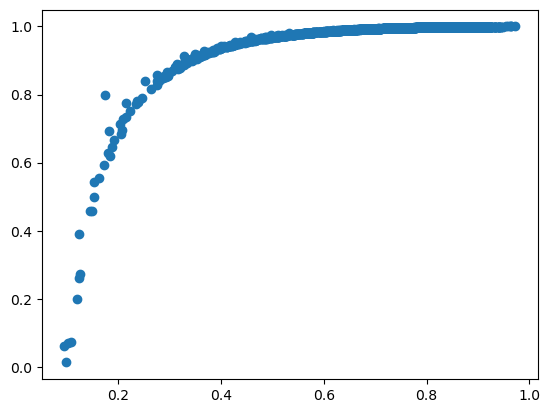

In [38]:
profit_dyn = np.array(profit_dyn)
profit_stat = np.array(profit_stat)
revenue_dyn = np.array(revenue_dyn)
plt.scatter(profit_dyn / revenue_dyn, profit_stat/profit_dyn)

In [32]:
profit_stat.sort()
profit_stat

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.10880403e-01, 6.94758008e-01, 1.15948959e+00,
       5.75350321e+00, 7.63251465e+00, 8.94545053e+00, 9.41785571e+00,
       1.03321582e+01, 1.11586626e+01, 1.29007410e+01, 1.30151801e+01,
       1.41503538e+01, 1.94869916e+01, 1.98995974e+01, 2.39131656e+01,
       2.50519770e+01, 2.57776271e+01, 2.75173842e+01, 2.75723439e+01,
       2.79907085e+01, 2.81038404e+01, 2.88497551e+01, 2.96108606e+01,
       3.13157174e+01, 3.30451834e+01, 3.46676839e+01, 3.65964258e+01,
       3.70008999e+01, 3.70027025e+01, 3.73547521e+01, 3.76776717e+01,
       3.81517947e+01, 4.08052339e+01, 4.15804671e+01, 4.21111639e+01,
       4.34586429e+01, 4.39140437e+01, 4.39618972e+01, 4.43886478e+01,
      

## Instance ranges

In [221]:
# Linear Demand

a = 10
b = 1/200
lin_demand = LinearDemand(a=a, b=b)

K = 5000
h = 5
instance = LostSales(h=h, K=K, pi=0)

print(zero.optimal_profit_and_S(lin_demand, instance))
print(zero.static_profit_comp(instance, lin_demand, *zero.optimal_static_policy(instance, lin_demand)))

(2.8421709430404007e-11, 55)
0


In [3]:
zero.static_profit_comp(instance, lin_demand, 3, 150)

-102.5

In [11]:
# Exponential Demand

a_exp = 10
b_exp = 1/100
exp_demand = ExponentialDemand(a=a_exp, b=b_exp)

K = 5000
h = 5
instance = LostSales(h=h, K=K, pi=0)

print(zero.optimal_profit_and_S(exp_demand, instance))
print(zero.optimal_static_policy(instance, exp_demand))
print(zero.static_profit_comp(instance, exp_demand, *zero.optimal_static_policy(instance, exp_demand)))

(32.7175299403264, 67)
(1.4574074922416909, 54)
8.24074922416915


## Optimal Static Policy

In [259]:
a = 10
b = 1/200
lin_demand = LinearDemand(a=a, b=b)

K = 6000
h = 6
instance = LostSales(h=h, K=K, pi=0)

def profit(l, s):
    if s == 0:
        return 0
    return l * lin_demand.price(l) -K*l/s - (s+1)*h/2

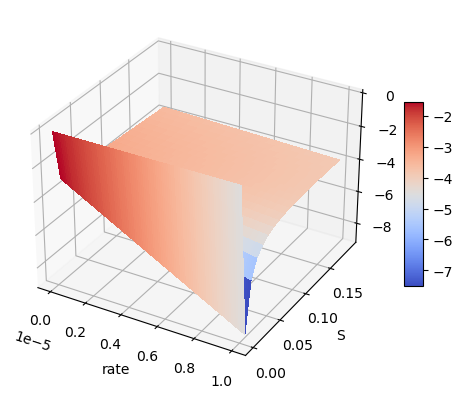

In [297]:
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ls = np.linspace(0, 0.00001, 100)
levels = np.arange(0, 0.2, 0.01)
Ls, levels = np.meshgrid(Ls, levels)
profits = np.array([[profit(l, s) for l, s in zip(ls, ss)] for ls, ss in zip(Ls, levels)])

surf = ax.plot_surface(Ls, levels, profits, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("rate")
ax.set_ylabel("S")
fig.colorbar(surf, shrink=0.5, aspect=10)

In [22]:
for a, b in zip(Ls, levels):
    for i, j in zip(a,b):
        print(i,j)

0.1 1
0.4040816326530612 1
0.7081632653061224 1
1.0122448979591836 1
1.316326530612245 1
1.620408163265306 1
1.9244897959183673 1
2.2285714285714286 1
2.5326530612244897 1
2.836734693877551 1
3.140816326530612 1
3.4448979591836735 1
3.7489795918367346 1
4.053061224489795 1
4.357142857142857 1
4.661224489795917 1
4.965306122448979 1
5.2693877551020405 1
5.573469387755101 1
5.877551020408163 1
6.181632653061223 1
6.485714285714285 1
6.789795918367346 1
7.093877551020407 1
7.397959183673469 1
7.70204081632653 1
8.00612244897959 1
8.310204081632651 1
8.614285714285714 1
8.918367346938775 1
9.222448979591835 1
9.526530612244898 1
9.830612244897958 1
10.134693877551019 1
10.438775510204081 1
10.742857142857142 1
11.046938775510203 1
11.351020408163265 1
11.655102040816326 1
11.959183673469386 1
12.263265306122447 1
12.56734693877551 1
12.87142857142857 1
13.17551020408163 1
13.479591836734693 1
13.783673469387754 1
14.087755102040814 1
14.391836734693877 1
14.695918367346938 1
15.0 1
0.1 2
0

In [45]:
np.dstack((Ls, levels))[0,0]

array([0.1, 3. ])

## Bad holding cost ratio for zero lead time backlogging model (linear demand) 

In [36]:
a = 30
b = 1/15
lin_demand = LinearDemand(a=a, b=b) # linear demand: lambda = a(1-bp)

profit = 0.1
S = 1
s = -2
states = np.arange(s+1, S+1)
h = a/4/b - profit
pi = h
instance = Backlog(h=h, K=10, pi=pi) # set a random K value
K = sum([zero.g(instance, lin_demand, i, profit) for i in states])
instance = Backlog(h=h, K=K, pi=pi)

In [37]:
state_space = ZeroLeadTime(s=s, S=S)
policy = ZeroLeadTimePolicy(instance=instance, demand=lin_demand, state_space=state_space)

In [38]:
policy.set_optimal_policy()

In [49]:
def get_x_width(rates):
    return np.r_[0, np.cumsum(1/rates)[:-1]] / np.sum(1/rates), 1/rates/np.sum(1/rates)

rates = policy.rates
stat_rate = policy.static_rate
heights = instance.holding(states)
x, width = get_x_width(rates)
x_stat, width_stat = get_x_width(stat_rate*np.ones_like(states))

In [50]:
x, width

(array([0.       , 0.0281365, 0.9718635]),
 array([0.0281365 , 0.94372699, 0.0281365 ]))

In [51]:
x_stat, width_stat

(array([0.        , 0.33333333, 0.66666667]),
 array([0.33333333, 0.33333333, 0.33333333]))

Text(0.5, 0, 'proportion time spent state')

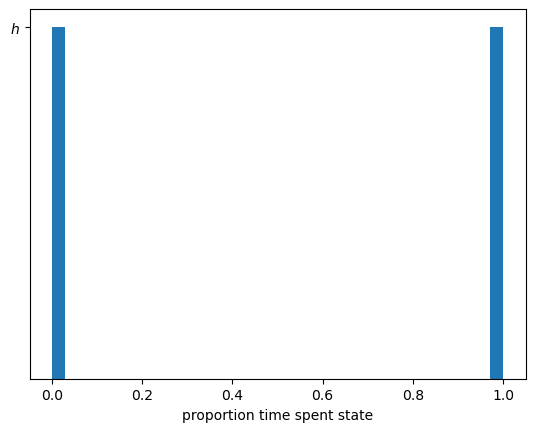

In [55]:
fig, ax = plt.subplots()
ax.bar(x, heights, width, align='edge')
ax.set_yticks([h])
ax.set_yticklabels(["$h$"])
ax.set_xlabel("proportion time spent state")

Text(0.5, 0, 'proportion time spent state')

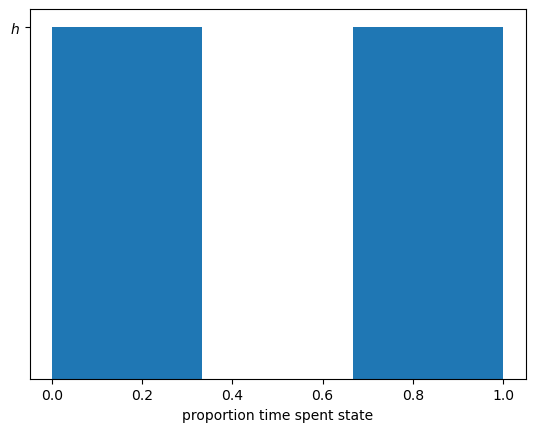

In [59]:
fig, ax = plt.subplots()
ax.bar(x_stat, heights, width_stat, align='edge')
ax.set_yticks([h])
ax.set_yticklabels(["$h$"])
ax.set_xlabel("proportion time spent state")

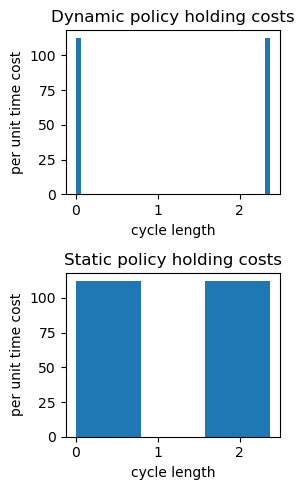

In [17]:
fig, ax = plt.subplots(2,1, figsize=(3,5))
ax[0].bar(x, heights, width, align='edge')
ax[1].bar(x_stat, heights, width_stat, align='edge')

[ax[i].set_ylabel("per unit time cost") for i in range(0,2)]
[ax[i].set_xlabel("cycle length") for i in range(0,2)]

ax[0].set_title("Dynamic policy holding costs")
ax[1].set_title("Static policy holding costs")

plt.tight_layout()

## Worst case plots for zero leadtime

In [21]:
a = 30
b = 1/15
exp_demand = ExponentialDemand(a=a, b=b) # Exponential demand: lambda = ae^(-bp)
hold_ratios_exp = []
cost_ratios_exp = []
order_sizes_exp = np.arange(1,8001,50)

for i, S in enumerate(order_sizes_exp):
    instance = exp_demand.optimal_instance_zero_leadtime(s=0, S=S, profit=0)
    state_space = ZeroLeadTime(s=0, S=S)
    policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
    # policy.rates = b * (np.arange(1,S+1)*instance.holding_cost)
    policy.set_optimal_policy()
    
    dyn_hold = policy.result.holding
    dyn_costs = policy.result.costs
    stat_hold = policy.static_result.holding
    
    alpha = stat_hold / dyn_hold
    sstatic = -0.5 + (0.25 + S * (S + 1) / alpha)**0.5
    # print(S / np.floor(sstatic), alpha * (np.ceil(sstatic) + 1) / (S + 1))
    if S / np.floor(sstatic) < alpha * (np.ceil(sstatic) + 1) / (S + 1):
        sstatic = np.floor(sstatic)
    else:
        sstatic = np.ceil(sstatic)
        
    state_space_static = ZeroLeadTime(s=0, S=sstatic)
    static_policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space_static)
    static_policy.rates = policy.static_rate * np.ones(state_space_static.shape)
    stat_costs = static_policy.result.costs
    
    hold_ratios_exp.append(stat_hold / dyn_hold)
    cost_ratios_exp.append(stat_costs / dyn_costs)
    
    print(S, hold_ratios_exp[i], cost_ratios_exp[i], policy.profit)

1 1.0 1.0 -2.842170943040401e-14
51 2.303708680740477 1.525292232173141 7.105427357601002e-15
101 2.624368355376914 1.6249170794209018 3.552713678800501e-15
151 2.817437324446883 1.682318047567469 -3.552713678800501e-15
201 2.956137379679998 1.7224405244961556 3.552713678800501e-15
251 3.0644903324687056 1.7531758694778585 3.552713678800501e-15
301 3.1534349071069268 1.7780699561649136 1.0658141036401503e-14
351 3.2288858277362182 1.7989453847380572 -1.0658141036401503e-14
401 3.2944067700277917 1.816901274266854 1.7763568394002505e-14
451 3.3523122410004746 1.8326160761921864 3.552713678800501e-15
501 3.4041909758229 1.8465966971362042 -3.552713678800501e-15
551 3.451180959615966 1.859177408583305 -2.1316282072803006e-14
601 3.4941253525712876 1.8706067436824023 2.4868995751603507e-14
651 3.5336663133094657 1.881073856065382 3.552713678800501e-15
701 3.5703042278907198 1.8907256825962862 -1.4210854715202004e-14
751 3.6044366075888523 1.8996689041055663 3.552713678800501e-14
801 3.6363

6501 4.679221589794758 2.163344344054726 -8.881784197001252e-14
6551 4.683047237542841 2.164227208755746 1.4210854715202004e-14
6601 4.6868438318923555 2.1651030242958824 -1.7763568394002505e-14
6651 4.690611810836382 2.1659719005166953 -3.907985046680551e-14
6701 4.694351602537155 2.1668339447611014 -2.842170943040401e-14
6751 4.698063625618108 2.167689071366131 -3.907985046680551e-14
6801 4.701748289445141 2.168537730901157 7.460698725481052e-14
6851 4.705405994397596 2.1693798654839966 5.3290705182007514e-14
6901 4.709037132129397 2.1702155732263413 1.4210854715202004e-14
6951 4.712642085820748 2.17104495008204 -6.750155989720952e-14
7001 4.716221230420877 2.1718679355144377 2.1316282072803006e-14
7051 4.7197749328820695 2.1726848910272394 -3.907985046680551e-14
7101 4.723303552385514 2.173495790725283 3.552713678800501e-15
7151 4.726807440559185 2.1743007225656172 0.0
7201 4.730286941688173 2.175099772633351 -1.0658141036401503e-14
7251 4.733742392917707 2.1758928669193045 2.131628

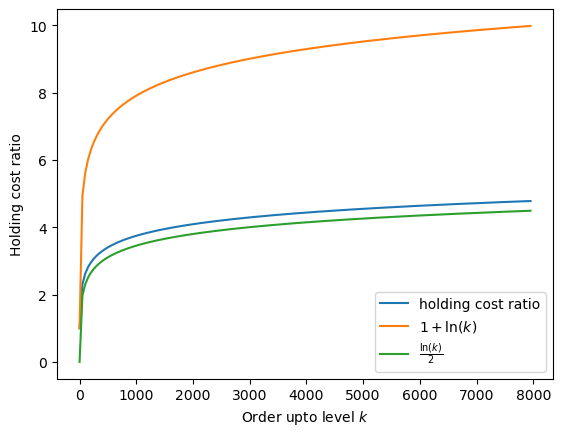

In [25]:
plt.plot(order_sizes_exp, hold_ratios_exp, label="holding cost ratio")
# plt.plot(order_sizes_exp, 0.5*(np.log(order_sizes_exp)+1)*(1 + 1/order_sizes_exp), label="$\\frac{\ln(eS)}{2}\\left(1+\\frac{1}{S}\\right)$")
plt.plot(order_sizes_exp, np.log(order_sizes_exp)+1, label="$1 + \\ln(k)$")
# plt.plot(order_sizes_exp, np.log(order_sizes_exp)+1, label="$\\frac{\ln(eS)}{2}\\left(1+\\frac{1}{S}\\right)$")
plt.plot(order_sizes_exp, 0.5*(np.log(order_sizes_exp)), label="$\\frac{\\ln(k)}{2}$")
plt.ylabel("Holding cost ratio")
plt.xlabel("Order upto level $k$")
# plt.suptitle("Tight example sequence for holding cost ratio")
# plt.title("Demand: Exponential, Policy: $(S, \lambda_{static} \cdot \mathbf{1})$")
plt.legend()
plt.savefig("worst_case_exp", format='pdf')

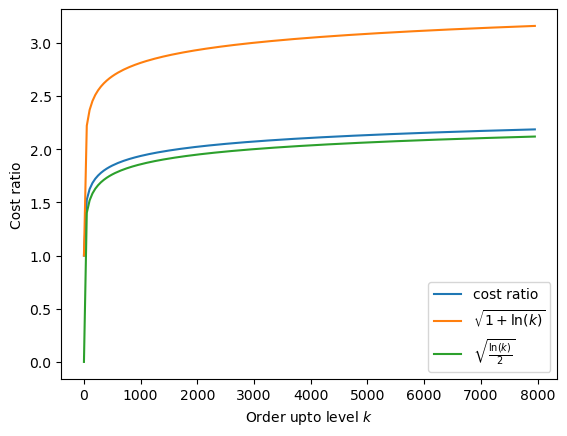

In [26]:
# max_cost_ratios_exp = np.sqrt(0.5*(np.log(order_sizes_exp)+1)*(1+(1+np.log(order_sizes_exp))/order_sizes_exp))
# max_cost_ratios_exp = np.sqrt(0.5*(order_sizes_exp + 1)*(np.log(order_sizes_exp)+1) / (order_sizes_exp+1))
plt.plot(order_sizes_exp, cost_ratios_exp, label="cost ratio")
plt.plot(order_sizes_exp, np.sqrt(1+np.log(order_sizes_exp)), label="$\sqrt{1+\\ln(k)}$")
# plt.plot(order_sizes_exp, max_cost_ratios_exp, label="$\sqrt{\\frac{\ln(eS)}{2}\cdot\\left(1 + \\frac{\ln(eS)}{S}\\right)}$")
plt.plot(order_sizes_exp, np.sqrt(0.5*(np.log(order_sizes_exp))), label="$\sqrt{\\frac{\\ln(k)}{2}}$")
plt.ylabel("Cost ratio")
plt.xlabel("Order upto level $k$")
# plt.suptitle("Tight example sequence for total cost ratio bound")
# plt.title("Demand: Exponential, Policy: $(S_{static}, \lambda_{static} \cdot \mathbf{1})$")
plt.legend()
plt.savefig("worst_case_exp_2", format='pdf')

In [3]:
a = 30
b = 1/15
exp_demand = ExponentialDemand(a=a, b=b) # linear demand: lambda = a(1-bp)
S = 32000
instance = exp_demand.optimal_instance_zero_leadtime(s=0, S=S, profit=0)
state_space = ZeroLeadTime(s=0, S=S)
policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
policy.rates = b * (np.arange(1,S+1)*instance.holding_cost)
print(S, policy.holding_cost_ratio, policy.profit)

32000 5.475532340839628 -1.1901590823981678e-13


In [10]:
a = 30
b = 1/15
exp_demand = ExponentialDemand(a=a, b=b) # Exponential demand: lambda = ae^(-bp)
cost_ratios_exp = []
order_sizes_exp = np.arange(1,8001,25)

for i, S in enumerate(order_sizes_exp):
    instance = exp_demand.optimal_instance_zero_leadtime(s=0, S=S, profit=0)
    state_space = ZeroLeadTime(s=0, S=S)
    policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space)
    policy.rates = b * (np.arange(1,S+1)*instance.holding_cost)
    optimal_costs = policy.result.holding + policy.result.ordering
    
    ratio = (S+1) * (np.log(S) + 1) / 2 / S
    S_static = np.ceil(S / np.sqrt(ratio))
    state_space_static = ZeroLeadTime(s=0, S=S_static)
    static_policy = ZeroLeadTimePolicy(instance=instance, demand=exp_demand, state_space=state_space_static)
    static_policy.rates = policy.static_rate * np.ones(state_space_static.shape)
    static_costs = static_policy.result.holding + static_policy.result.ordering
    cost_ratios_exp.append(static_costs / optimal_costs)
    print(S, cost_ratios_exp[i], policy.profit)

1 1.0 0.0
26 1.425463840358023 1.4210854715202004e-14
51 1.5252922321755684 0.0
76 1.5838123604089904 4.263256414560601e-14
101 1.62547994822722 0.0
126 1.6569146166923079 -1.4210854715202004e-14
151 1.6827902227460767 -7.105427357601002e-15
176 1.7044530971664065 0.0
201 1.7230431608157308 7.105427357601002e-15
226 1.7393039239723607 -1.0658141036401503e-14
251 1.753743523267666 3.552713678800501e-15
276 1.7667229563798106 -2.4868995751603507e-14
301 1.778507093626321 1.4210854715202004e-14
326 1.789528450959474 -3.552713678800501e-15
351 1.7994401255480876 -7.105427357601002e-15
376 1.8088467140815305 -2.1316282072803006e-14
401 1.8173895978672827 1.7763568394002505e-14
426 1.8255805402043892 0.0
451 1.8332721522557645 0.0
476 1.840328521992037 -3.552713678800501e-15
501 1.8471769985965218 0.0
526 1.8536675469550044 1.0658141036401503e-14
551 1.859834053216493 -1.0658141036401503e-14
576 1.865548391199276 -1.4210854715202004e-14
601 1.871154708086517 2.1316282072803006e-14
626 1.8765

4626 2.124299180465975 3.552713678800501e-15
4651 2.1249287479501966 -9.947598300641403e-14
4676 2.1255766064570745 -5.684341886080802e-14
4701 2.1261988594285093 1.0658141036401503e-14
4726 2.126817597722202 -9.237055564881302e-14
4751 2.127432860279876 7.105427357601002e-14
4776 2.1280446854099098 8.881784197001252e-14
4801 2.1286531108007805 -8.881784197001252e-14
4826 2.1292581735341582 7.105427357601002e-14
4851 2.129859910097672 7.460698725481052e-14
4876 2.130479391268217 3.907985046680551e-14
4901 2.131074421933125 4.973799150320701e-14
4926 2.1316662334369862 7.105427357601002e-15
4951 2.1322548600118956 -1.0302869668521453e-13
4976 2.1328403353546417 -9.592326932761353e-14
5001 2.1334226926376547 -4.618527782440651e-14
5026 2.1340019645196793 6.039613253960852e-14
5051 2.134578183156174 1.0658141036401503e-13
5076 2.1351715601761003 -1.2079226507921703e-13
5101 2.1357416102801086 7.815970093361102e-14
5126 2.1363087017119953 -7.105427357601002e-15
5151 2.1368728647095545 -7.1